In [1]:
%matplotlib inline
from skimage import io, filters
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from lgan.diffeomorphism import tf_diffeomorphism
from tqdm import tqdm

In [2]:
batch_size = 32 #batch size
input_dim = 128 #dim x and z input_size

#mnist data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
X_train = mnist.train.images
Y_train = mnist.train.labels
X_train = X_train.reshape(55000,28,28,1)

#reorganize labels
y_train = np.zeros(55000)
for i in range(len(Y_train)):
    y_train[i]= np.argwhere(Y_train[i]==1)#reshape

#create mean Images
numberImages = np.zeros((10,28,28,1))
for i in range(10):
    numbers = np.argwhere(y_train==i)
    z = X_train[numbers] #collect all images with number    
    numberImages[i] = np.mean(z, axis=0)

X_train = X_train.reshape(55000,784)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
#simple plot function
def plot(samples, labels,y,x):
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(y, x)
    gs.update(wspace=0.05, hspace=0.05)
    plt.subplots_adjust(left=None, bottom=None, right=1, top=1.3,
                wspace=None, hspace=None)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.title(labels[i])
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')   
    return fig

In [4]:
'''
#try Diffeomorphism
image = numberImages
image = np.reshape(image, (10,28,28,1))
print(image.shape)
session = tf.InteractiveSession()
diff_map =  np.random.uniform(-0.5,0.3, size=(10,3, 3, 2)) #batch_size, diff_height, diff_width, 2
dif_image = tf_diffeomorphism(image,diff_map)
plot(image,np.zeros(10))
div_image = dif_image.eval()
plot(div_image,np.ones(10))
'''

'\n#try Diffeomorphism\nimage = numberImages\nimage = np.reshape(image, (10,28,28,1))\nprint(image.shape)\nsession = tf.InteractiveSession()\ndiff_map =  np.random.uniform(-0.5,0.3, size=(10,3, 3, 2)) #batch_size, diff_height, diff_width, 2\ndif_image = tf_diffeomorphism(image,diff_map)\nplot(image,np.zeros(10))\ndiv_image = dif_image.eval()\nplot(div_image,np.ones(10))\n'

In [5]:
#get Mean Image for Dif Input
def getMeanImage(batch_size,label):
    images = np.zeros((batch_size,784))
    for i in range(batch_size):      
        l = np.argwhere(label[i]==1)
        index = l[0][0]
        images[i]= np.reshape(numberImages[index],784)
    return images

In [6]:
#sample for Generator: Random Mean Images 0-9 + Uniform Noise Vector + Label
def sample_z(batch_size):
    batch = np.zeros((batch_size,input_dim))
    labels = np.zeros((batch_size,10)) 
    for i in range(batch_size):
        vector = np.random.uniform(-1., 1., size=[input_dim]) #create noise vector of 100
        index = int(np.random.rand(1)*10)
        labels[i][index]= 1  #get random label 
        batch[i] = vector
    return (batch, labels)

In [7]:
def convLayer(layerinput, maps, kernel, stride,scope, act="relu"):
    layerinput = slim.conv2d(layerinput, maps, kernel,stride, weights_initializer=tf.truncated_normal_initializer(stddev=1e-1),
                  scope=scope,padding = 'SAME')
    if(act == "tanh"):        
        return tf.nn.tanh(layerinput)
    else:
        layerinput = slim.batch_norm(layerinput)
        return tf.nn.relu(layerinput) 

In [8]:
#Generator Variables
scalar = tf.Variable(tf.reduce_mean(tf.random_normal([1], stddev=0.1)))
multMatrix = tf.Variable(tf.random_normal([batch_size,8,49], stddev=0.1))

#Generator - add Detail
def generator_detail(noise, dif_image):
    with tf.variable_scope('generator_detail'):
        noise = tf.reshape(noise, (batch_size,16,8))
        noise = tf.matmul(noise, multMatrix) #49x16 Matrix=784
        noise = tf.reshape(noise,(batch_size, 28,28,1))
        noise = slim.batch_norm(noise)
        noise = tf.scalar_mul(0, noise)

        details = tf.reshape(dif_image, [batch_size, 28,28,1])
        
        detail_image = tf.add(details, noise)
        detail_image = convLayer(detail_image, 64, [3,3],2, scope='convDetail_1',act="tanh")
        detail_image = convLayer(detail_image, 128, [3,3],2, scope='convDetail_2',act="tanh")
        detail_image = slim.convolution2d_transpose(detail_image, 64, [3,3],2, scope='convDetail_4')
        #detail_image = slim.batch_norm(detail_image)
        detail_image = tf.nn.tanh(detail_image)
        detail_image = slim.convolution2d_transpose(detail_image, 32, [3,3],2, scope='convDetail_5')
        #detail_image = slim.batch_norm(detail_image)
        detail_image = tf.nn.tanh(detail_image)
        detail_image = convLayer(detail_image, 1, [3,3],1, scope='convDetail_6',act="tanh") 

        return detail_image

#Generator - predict parameters for Diffeomorphism
def generator_dif_paras(noise_vector):
    with tf.variable_scope('generator_diffeo'):
        params = tf.reshape(noise_vector,[batch_size,16,8,1])
        params = convLayer(params, 32, [3, 3],2, scope='convG_1')  
        params = convLayer(params, 1, [3, 3],2, scope='convG_2')
        params = tf.nn.tanh(params)
        params= tf.reshape(params, [batch_size,2,2,2]) 
        return params
    
#Main Generator
def generator(z,class_z,mean_image):
    with tf.variable_scope('generator'):
        mean_image = tf.reshape(mean_image,[batch_size, 28,28,1])
        class_z = slim.fully_connected(class_z, input_dim,weights_initializer=tf.truncated_normal_initializer(stddev=1e-1))
        class_z = tf.nn.relu(class_z)
        class_z = tf.nn.relu(z)
        noise = tf.add(z,class_z)
        
        dif_params = generator_dif_paras(noise)
        dif_image = tf_diffeomorphism(mean_image,dif_params) 
        detailed_image = generator_detail(noise, dif_image)
        return [detailed_image, dif_image]



In [9]:
def discriminator(x):
    with tf.variable_scope('discriminator'):
        x = tf.reshape(x,[batch_size,28,28,1])
        #net = slim.conv2d(x, 128, [3, 3], weights_initializer=tf.contrib.layers.xavier_initializer(), scope='convD_1')
        #net = slim.batch_norm(net)
        #net = tf.nn.relu(net)
        net = slim.conv2d(x, 16, [3, 3],2,weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
                          scope='convD_2',padding = 'SAME')
        net = tf.nn.relu(net)
        net = convLayer(net, 32, [3, 3],1,scope='convD_3')
        net = slim.convolution2d_transpose(net, 128, [3,3],2, weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
                          scope='convD_4',padding = 'SAME')
        net = slim.batch_norm(net)
        net = tf.nn.relu(net)
        net = convLayer(net, 32, [3,3],1, scope='convD_5')
        net = convLayer(net, 4, [3,3],1, scope='convD_6')
        return slim.fully_connected(net, num_outputs = 1,weights_initializer=tf.truncated_normal_initializer(stddev=0.1))


In [10]:
#Session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)


#input
Mean_image = tf.placeholder(tf.float32, shape=[batch_size, 784])
X = tf.placeholder(tf.float32, shape=[batch_size,784]) 
Z = tf.placeholder(tf.float32, shape=[batch_size, input_dim]) #random Noise 100
Class_z = tf.placeholder(tf.float32, shape=[batch_size, 10]) #class(label) of image
print(Class_z)

#Models
detail_image = generator(Z, Class_z, Mean_image) #Generator generate image
D_real = discriminator(X)
D_fake = discriminator(detail_image[0])

#variables V1
theta_D = sess.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator') 
theta_G = sess.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')
theta_G_detail = sess.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator_detail')


D_loss = tf.reduce_mean(D_real) - tf.reduce_mean(D_fake)
#added simple L1 Loss.
G_l1_loss = tf.multiply(0.001, tf.reduce_mean(tf.abs(detail_image[0]-detail_image[1])))

G_loss = -tf.reduce_mean(D_fake)+G_l1_loss

D_solver = (tf.train.RMSPropOptimizer(learning_rate=1e-4)
            .minimize(-D_loss, var_list=theta_D))
G_solver = (tf.train.RMSPropOptimizer(learning_rate=1e-4)
            .minimize(G_loss, var_list=theta_G))

clip_D = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in theta_D]


if not os.path.exists('out/'):
    os.makedirs('out/')

#initalize Variables    
sess.run(tf.global_variables_initializer())    

Tensor("Placeholder_3:0", shape=(32, 10), dtype=float32)


In [ ]:
logs_path = 'logs/lgan-log'

if not os.path.exists('logs/'):
    os.makedirs('logs/')
#Instantiate Tensorboard

# Create a summary to monitor cost tensor
tf.summary.scalar("D-loss", D_loss)
# Create a summary to monitor accuracy tensor
tf.summary.scalar("G-loss", G_loss)
# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())


100%|██████████| 500/500 [00:17<00:00, 27.97it/s]


Iter: 0; D loss: 0.01919; G_loss: -0.0002978


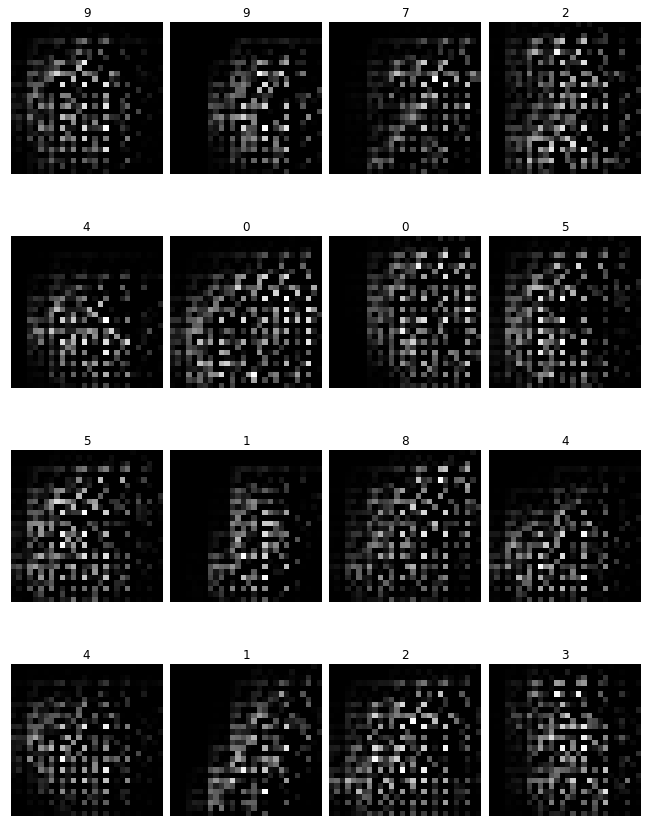

Iter: 100; D loss: 0.01944; G_loss: -0.0001587


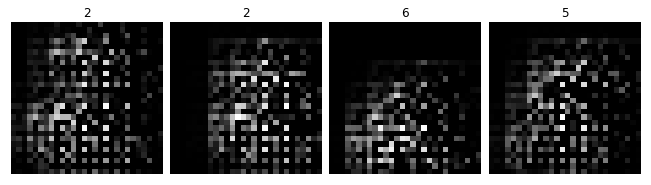

Iter: 200; D loss: 0.01947; G_loss: -0.0002043


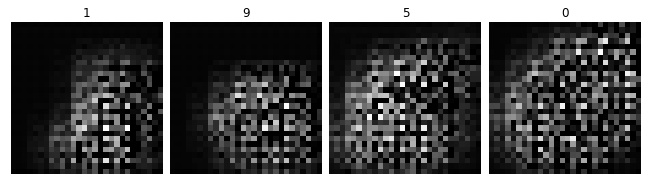

Iter: 300; D loss: 0.0196; G_loss: -0.0001463


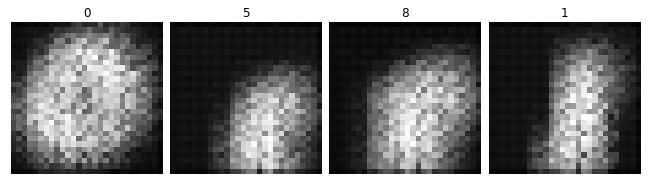

Iter: 400; D loss: 0.01958; G_loss: -0.0001929


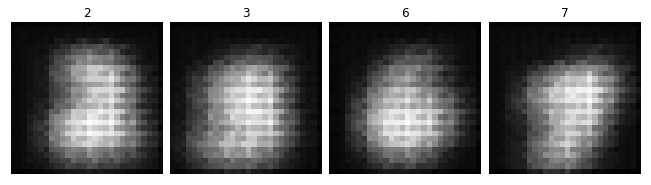

Iter: 500; D loss: 0.01951; G_loss: -0.0002231


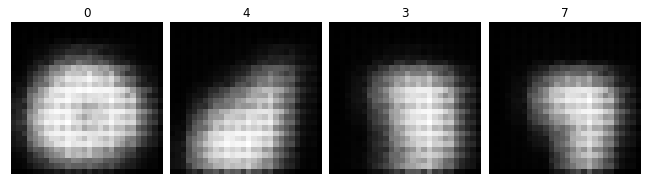

Iter: 600; D loss: 0.01942; G_loss: -0.000213


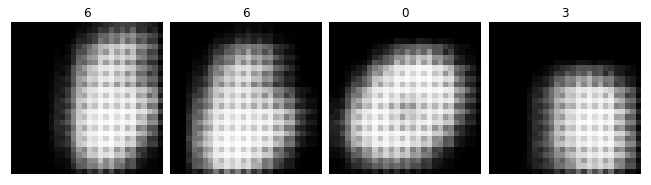

Iter: 700; D loss: 0.01942; G_loss: -0.0001499


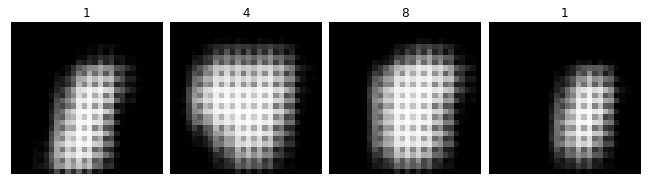

Iter: 800; D loss: 0.01957; G_loss: -0.0001678


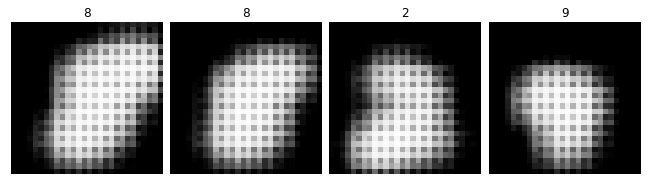

Iter: 900; D loss: 0.01959; G_loss: -0.0001497


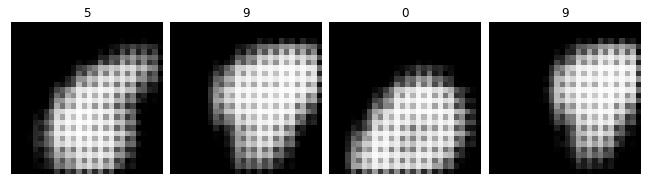

Iter: 1000; D loss: 0.01963; G_loss: -0.0001959


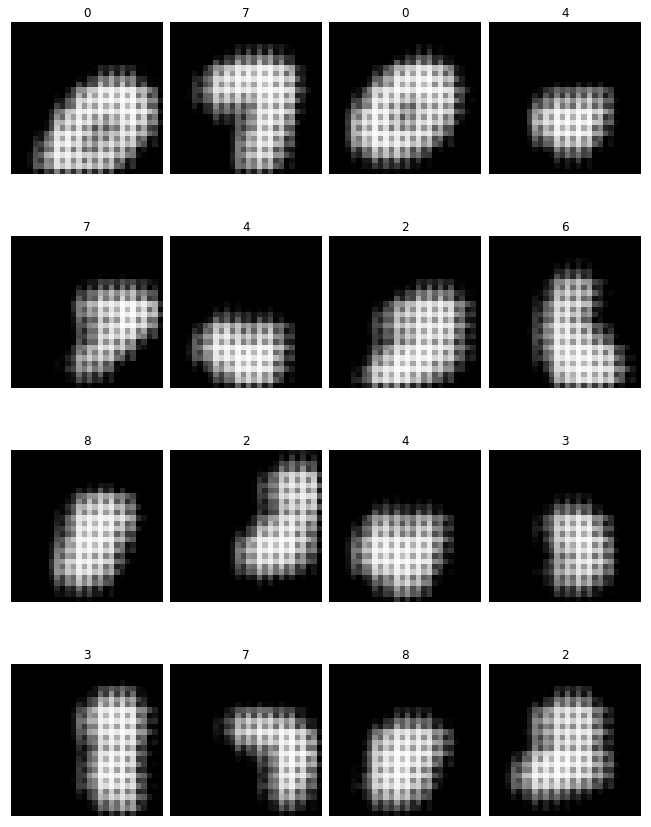

Iter: 1100; D loss: 0.01963; G_loss: -0.0002229


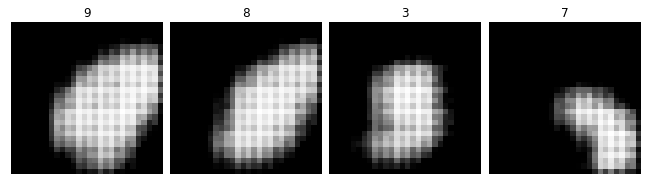

Iter: 1200; D loss: 0.01965; G_loss: -0.0002035


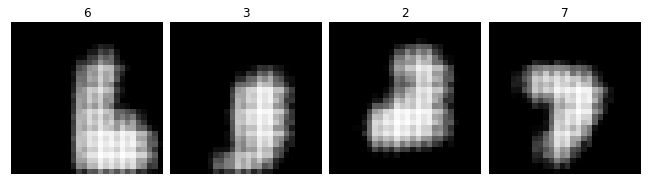

Iter: 1300; D loss: 0.01963; G_loss: -0.0002447


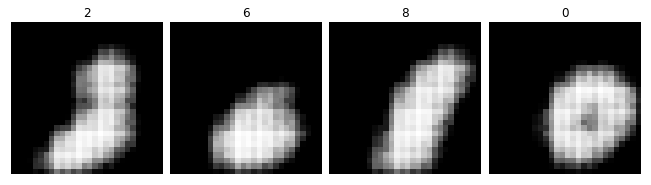

Iter: 1400; D loss: 0.01966; G_loss: -0.0002299


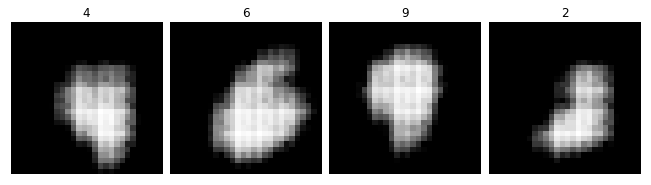

Iter: 1500; D loss: 0.01963; G_loss: -0.0002068


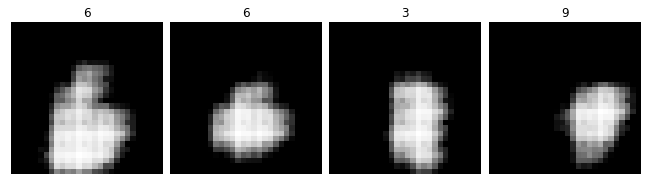

Iter: 1600; D loss: 0.01963; G_loss: -0.0002002


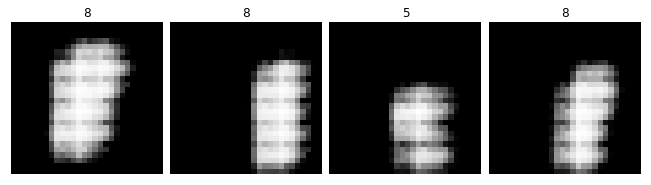

Iter: 1700; D loss: 0.01955; G_loss: -0.000217


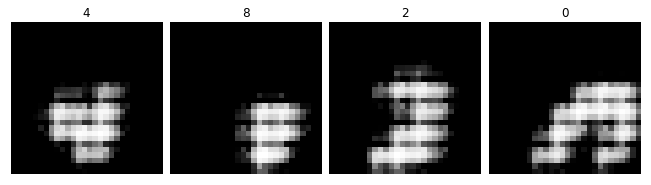

Iter: 1800; D loss: 0.01008; G_loss: -0.0003361


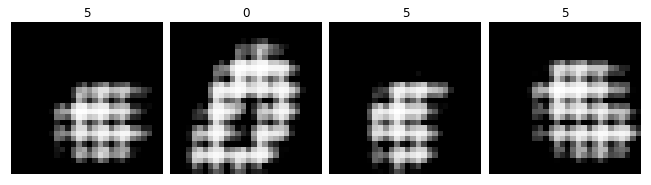

Iter: 1900; D loss: 0.01953; G_loss: -0.0002166


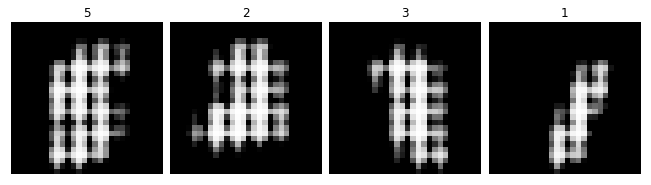

Iter: 2000; D loss: 0.01956; G_loss: -0.0001714


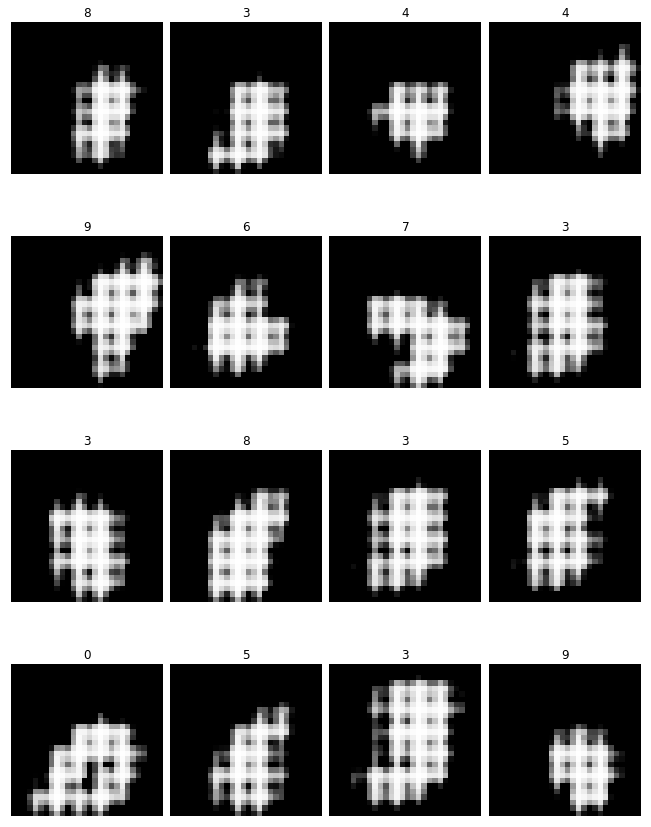

Iter: 2100; D loss: 0.01955; G_loss: -0.000193


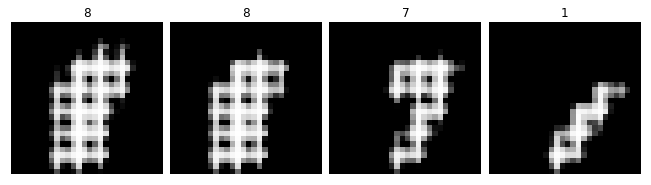

Iter: 2200; D loss: 0.01946; G_loss: -0.0002537


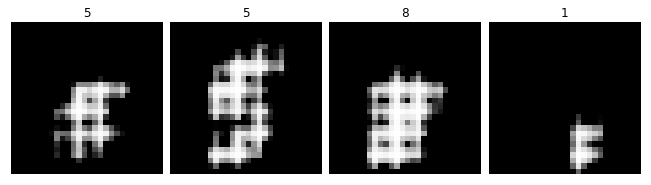

Iter: 2300; D loss: 0.01948; G_loss: -0.000249


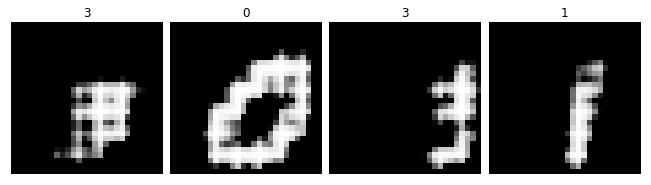

Iter: 2400; D loss: 0.01929; G_loss: -0.0003961


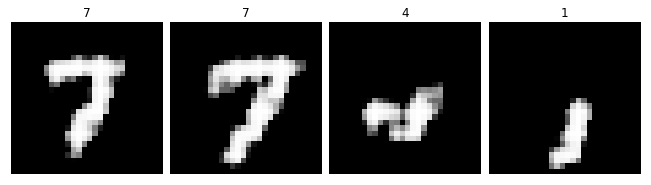

Iter: 2500; D loss: 0.01921; G_loss: -0.0003002


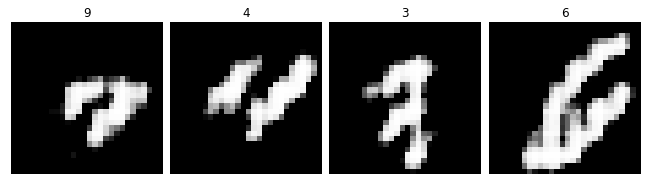

Iter: 2600; D loss: 0.00955; G_loss: -0.001706


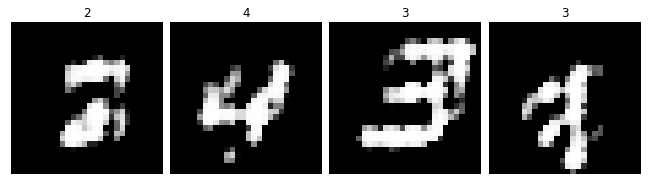

Iter: 2700; D loss: 0.01067; G_loss: -0.0004418


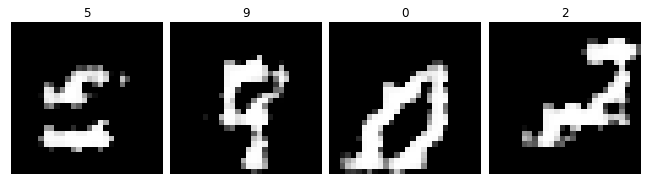

Iter: 2800; D loss: 0.01861; G_loss: -0.0004933


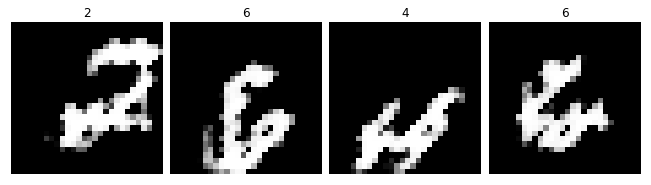

Iter: 2900; D loss: 0.01788; G_loss: -0.006729


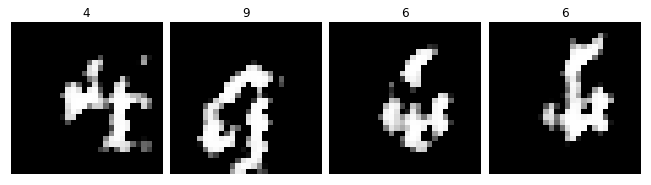

Iter: 3000; D loss: 0.01845; G_loss: -0.001294


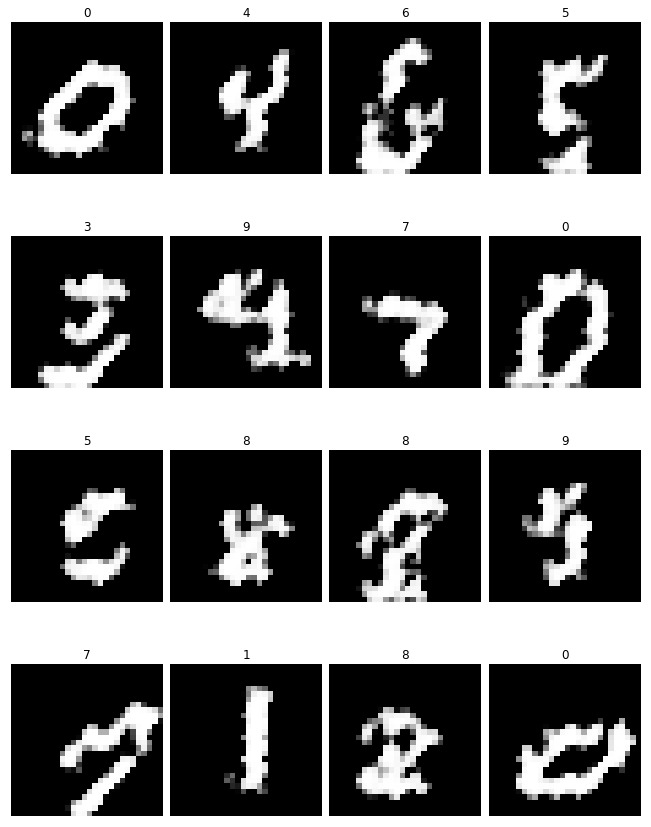

Iter: 3100; D loss: 0.01795; G_loss: -0.0005559


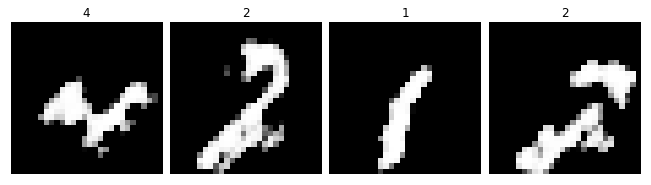

Iter: 3200; D loss: 0.01864; G_loss: -0.0004893


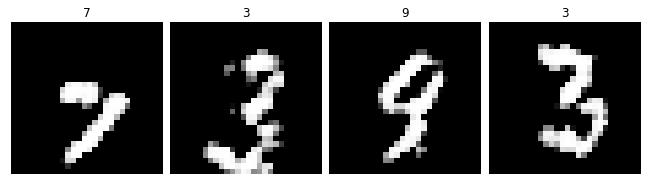

Iter: 3300; D loss: 0.01809; G_loss: -0.0006433


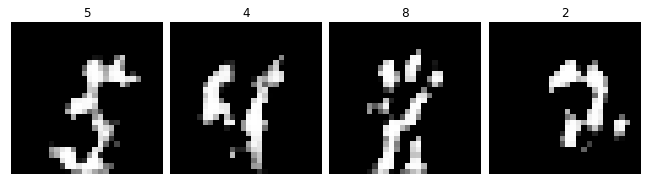

Iter: 3400; D loss: 0.01866; G_loss: -0.0003832


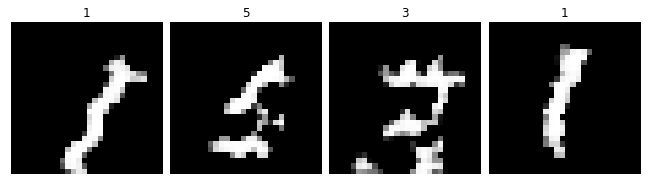

Iter: 3500; D loss: 0.01794; G_loss: -0.0006417


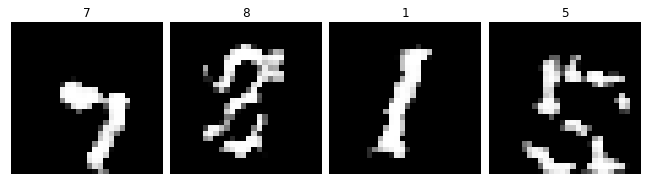

Iter: 3600; D loss: 0.01843; G_loss: -0.01534


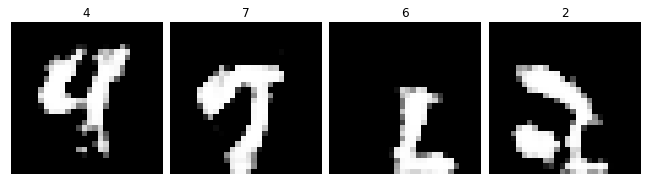

Iter: 3700; D loss: 0.0188; G_loss: -0.0004537


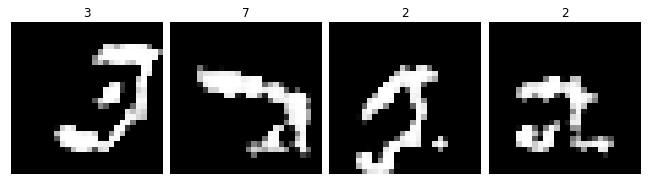

Iter: 3800; D loss: 0.01763; G_loss: -0.0006229


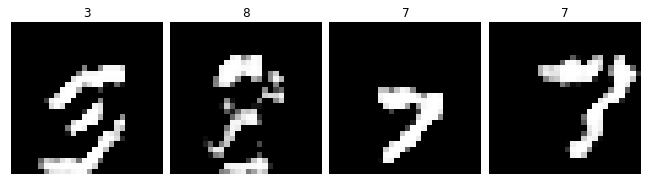

Iter: 3900; D loss: 0.01404; G_loss: -0.002047


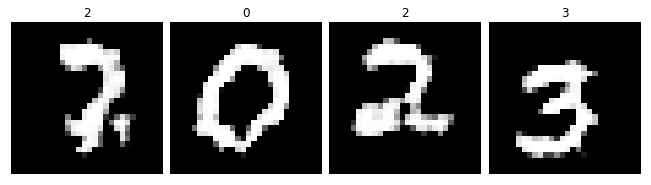

Iter: 4000; D loss: 0.01794; G_loss: -0.0005502


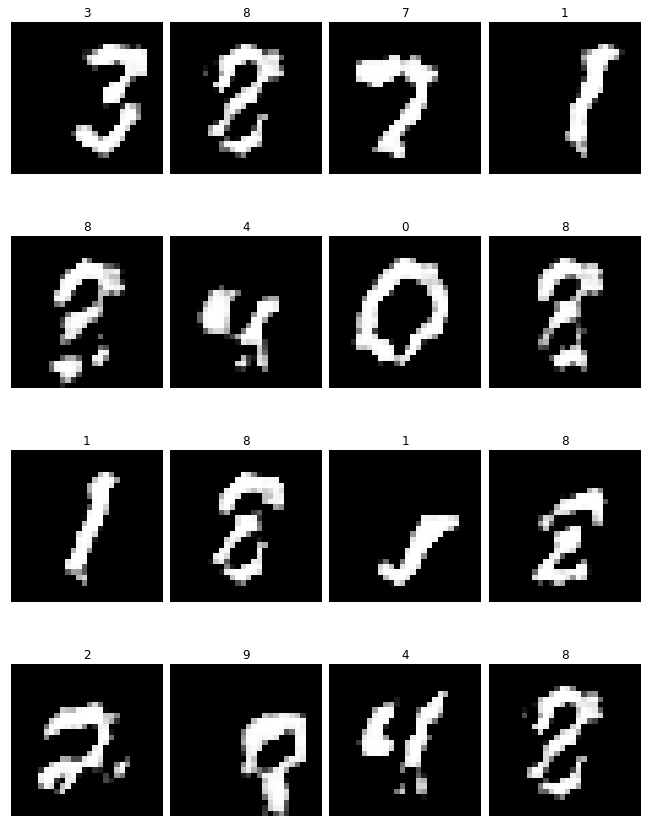

Iter: 4100; D loss: 0.01886; G_loss: -0.0004734


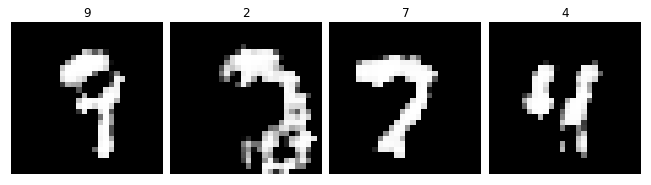

Iter: 4200; D loss: 0.01873; G_loss: -0.0004591


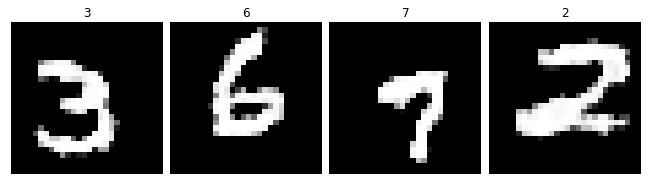

Iter: 4300; D loss: 0.01894; G_loss: -0.0004634


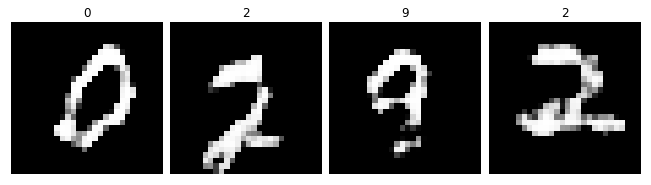

Iter: 4400; D loss: 0.01071; G_loss: -0.0004455


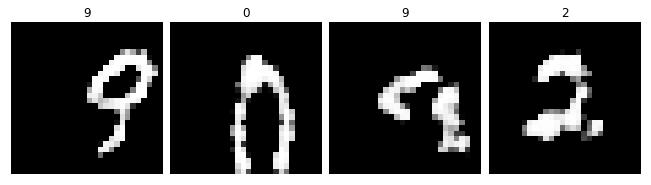

Iter: 4500; D loss: 0.01849; G_loss: -0.0004611


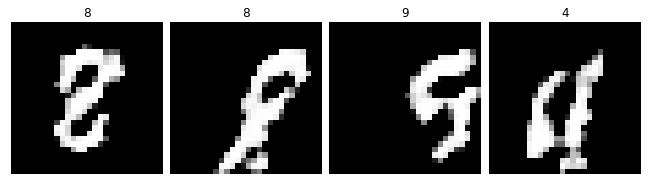

Iter: 4600; D loss: 0.0186; G_loss: -0.0005291


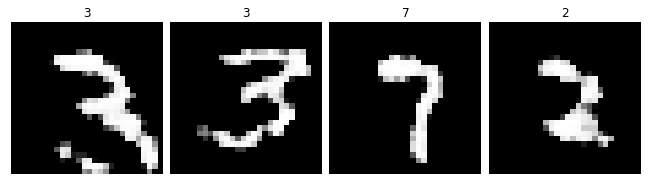

Iter: 4700; D loss: 0.01101; G_loss: -0.008958


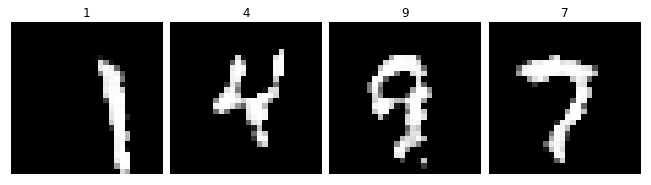

Iter: 4800; D loss: 0.01609; G_loss: -0.01084


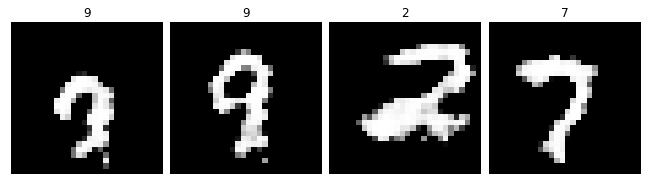

Iter: 4900; D loss: 0.008263; G_loss: -0.0005728


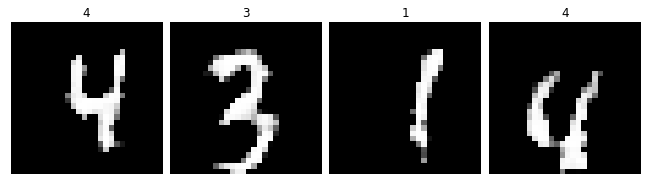

Iter: 5000; D loss: 0.0189; G_loss: -0.0004065


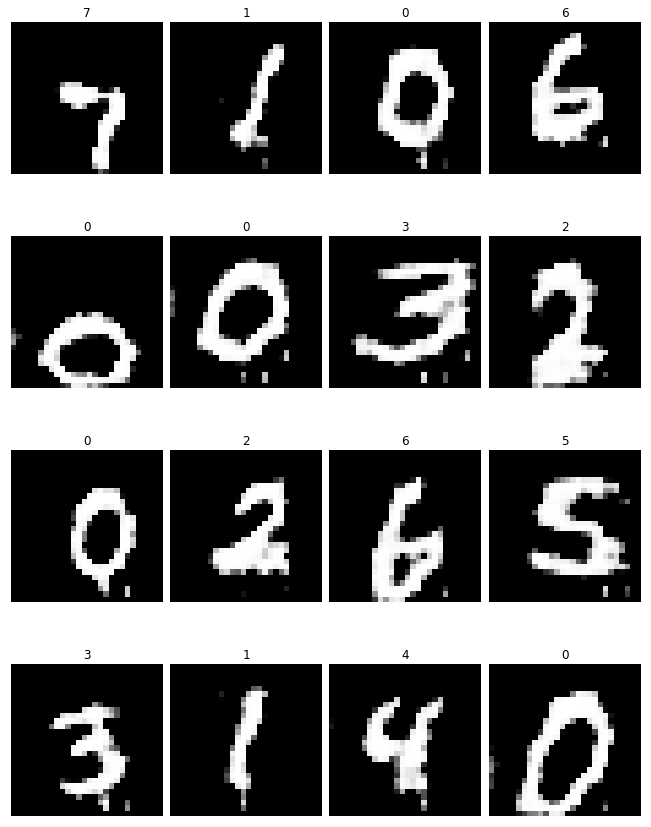

Iter: 5100; D loss: 0.01854; G_loss: -0.0003982


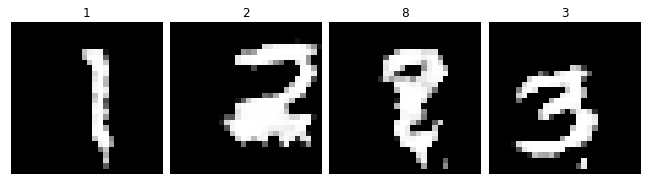

Iter: 5200; D loss: 0.0173; G_loss: -0.002025


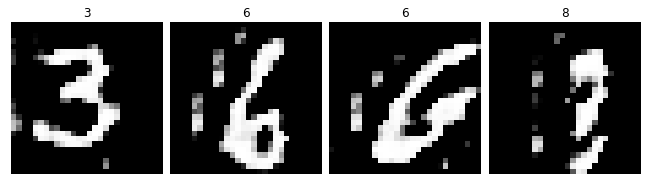

Iter: 5300; D loss: 0.01585; G_loss: -0.0008311


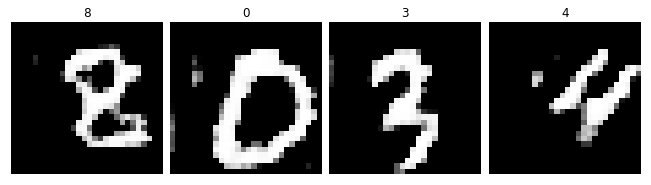

Iter: 5400; D loss: 0.01816; G_loss: -0.0007789


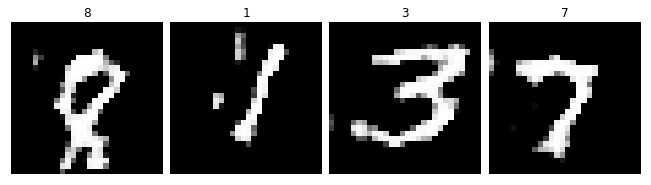

Iter: 5500; D loss: 0.01785; G_loss: -0.0009099


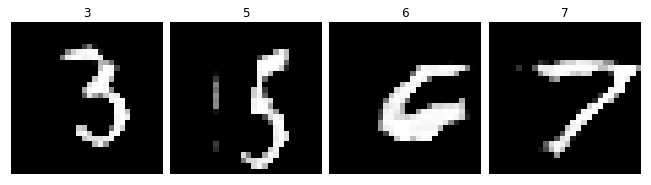

Iter: 5600; D loss: 0.0007724; G_loss: -0.01101


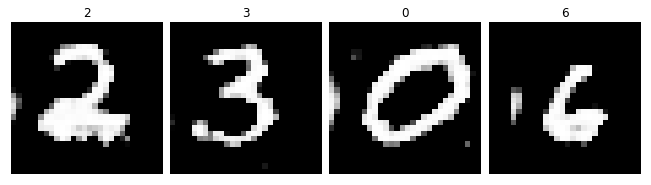

Iter: 5700; D loss: 0.01644; G_loss: -0.009263


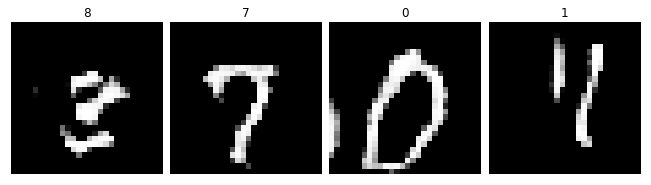

Iter: 5800; D loss: 0.01754; G_loss: -0.004812


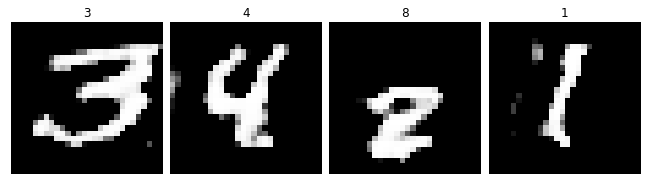

Iter: 5900; D loss: 0.01269; G_loss: -0.004912


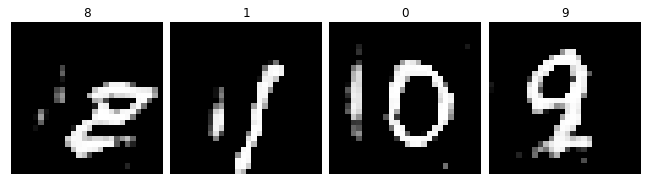

Iter: 6000; D loss: 0.01668; G_loss: -0.00144


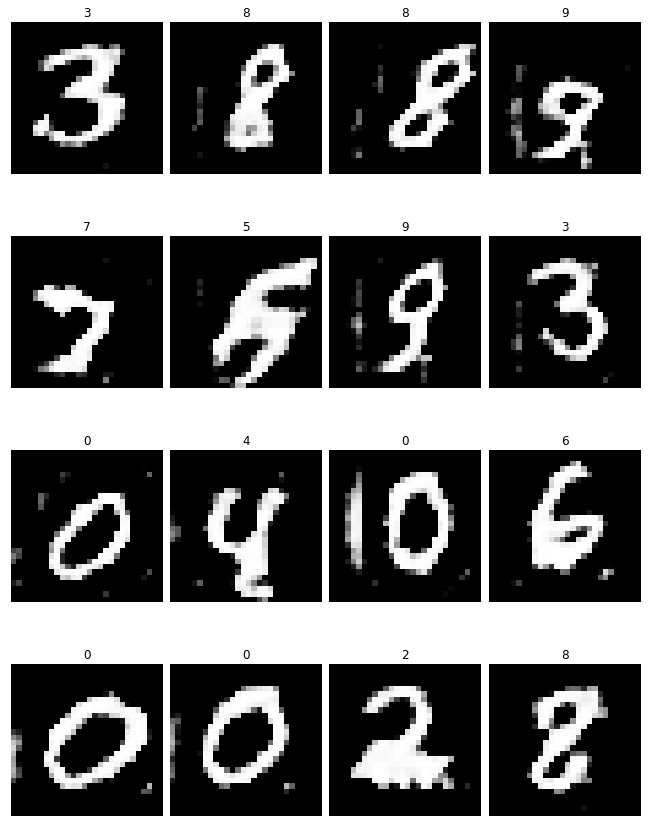

Iter: 6100; D loss: 0.0167; G_loss: -0.001786


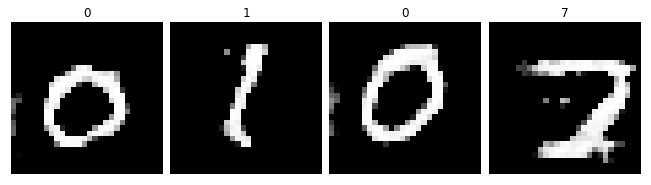

Iter: 6200; D loss: 0.01665; G_loss: -0.001822


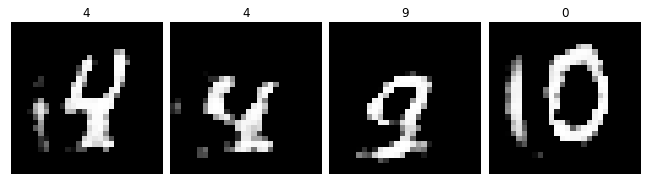

Iter: 6300; D loss: 0.003006; G_loss: -0.002624


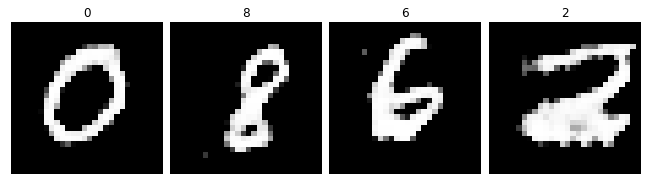

Iter: 6400; D loss: 0.01378; G_loss: -0.01571


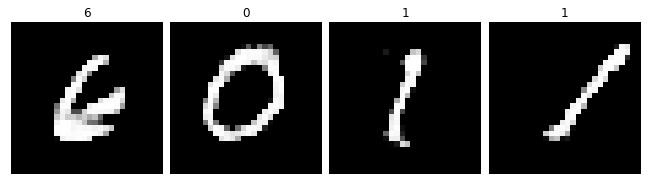

Iter: 6500; D loss: 0.005294; G_loss: -0.001898


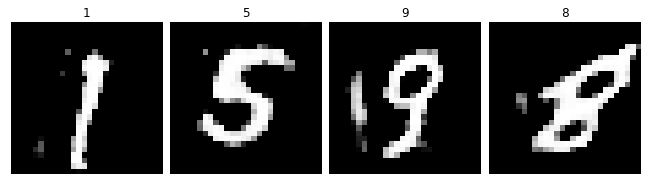

Iter: 6600; D loss: 0.01662; G_loss: -0.001303


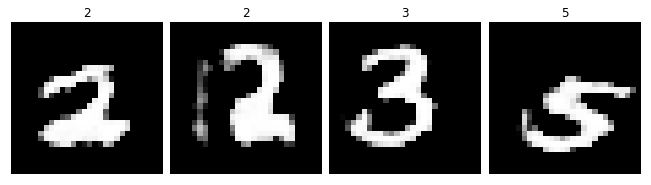

Iter: 6700; D loss: 0.0167; G_loss: -0.001404


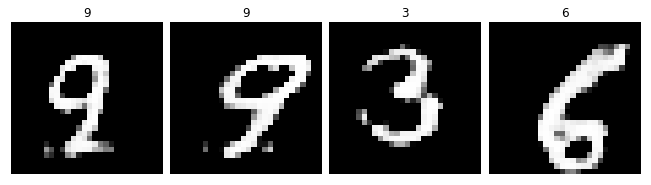

Iter: 6800; D loss: 0.009491; G_loss: -0.006399


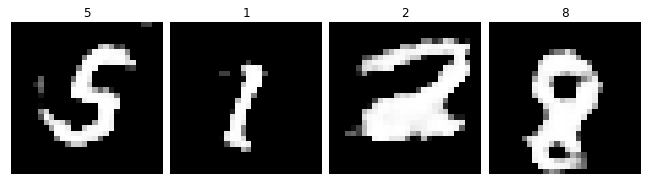

Iter: 6900; D loss: 0.008531; G_loss: -0.0007642


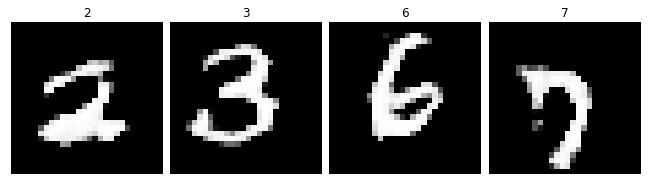

Iter: 7000; D loss: 0.01069; G_loss: -0.005916


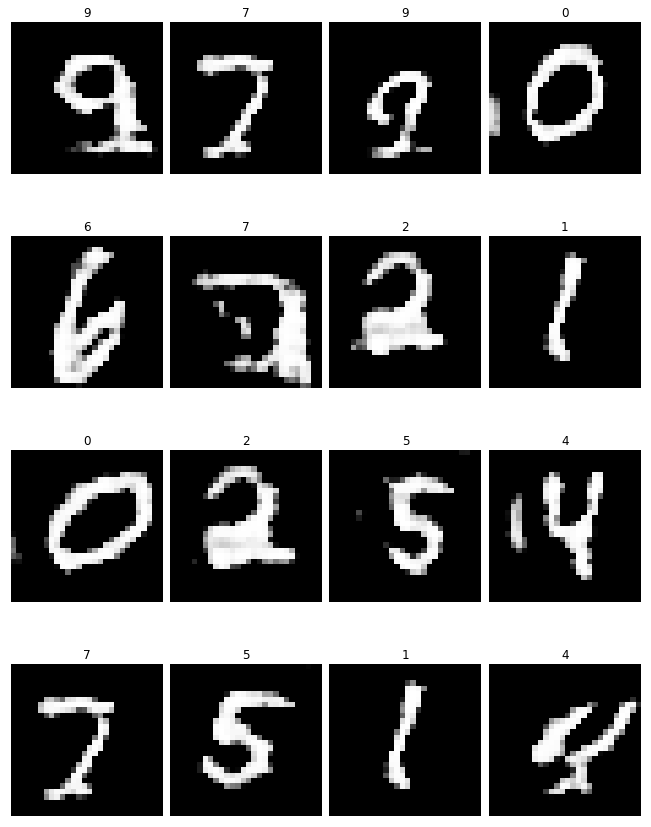

Iter: 7100; D loss: 0.004343; G_loss: -0.0009345


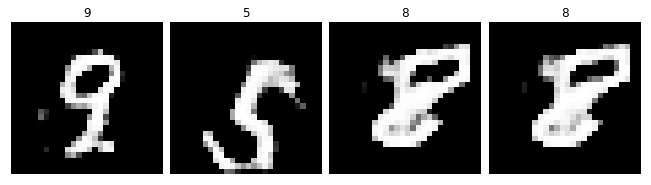

Iter: 7200; D loss: 0.008253; G_loss: -0.006446


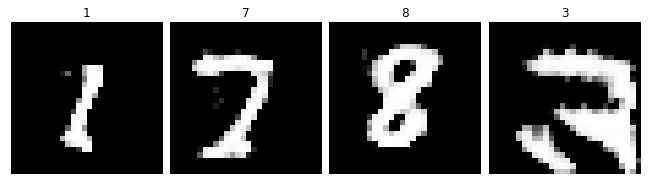

Iter: 7300; D loss: 0.01587; G_loss: -0.001605


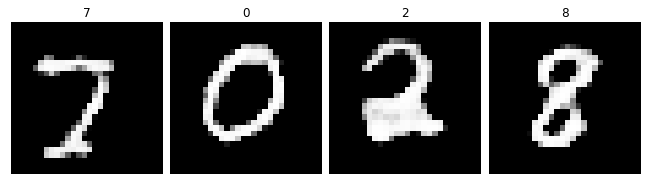

Iter: 7400; D loss: 0.008771; G_loss: -0.007865


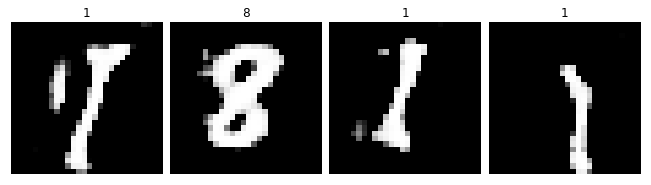

Iter: 7500; D loss: 0.0122; G_loss: -0.0009619


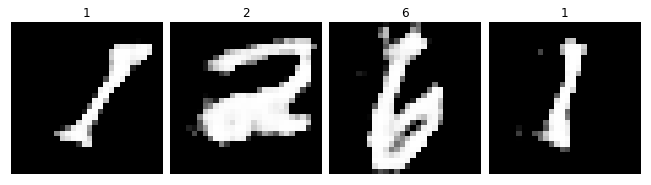

Iter: 7600; D loss: 0.007221; G_loss: -0.005157


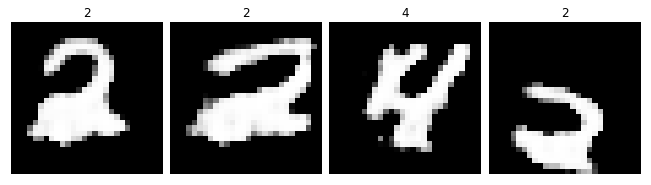

Iter: 7700; D loss: 0.01362; G_loss: -0.001139


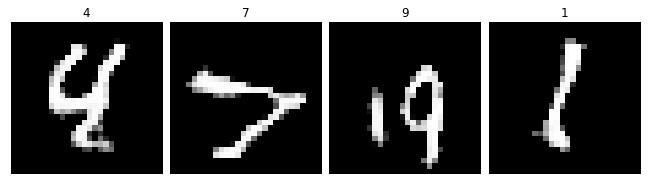

Iter: 7800; D loss: 0.01047; G_loss: -0.0008684


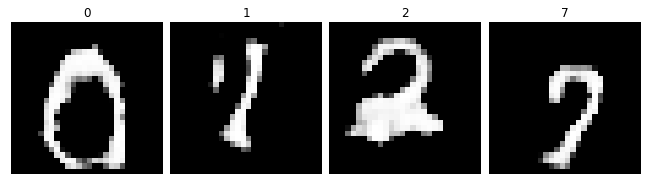

Iter: 7900; D loss: 0.01607; G_loss: -0.001279


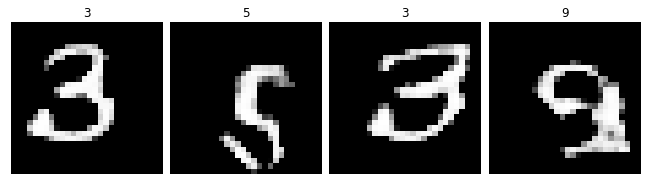

Iter: 8000; D loss: 0.006726; G_loss: -0.005241


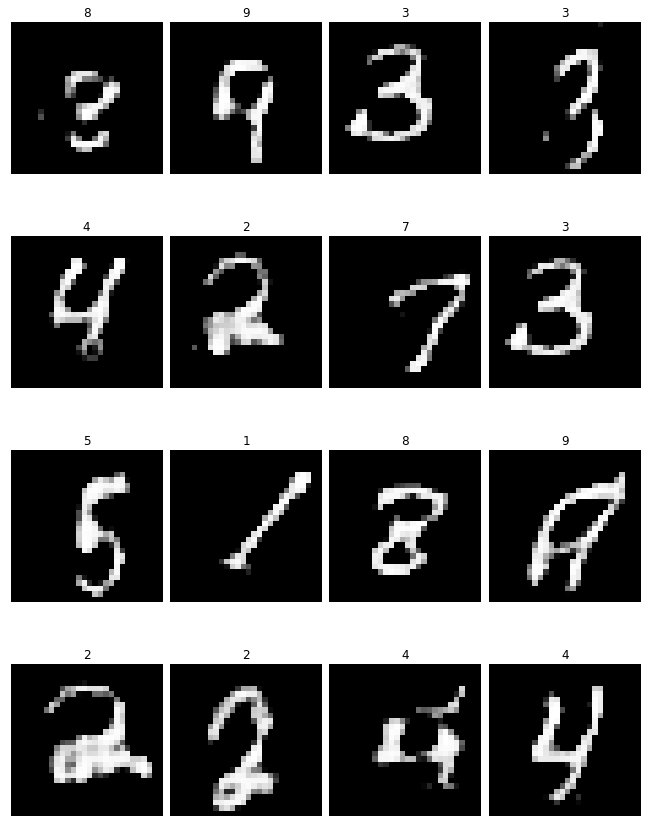

Iter: 8100; D loss: 0.01506; G_loss: -0.001029


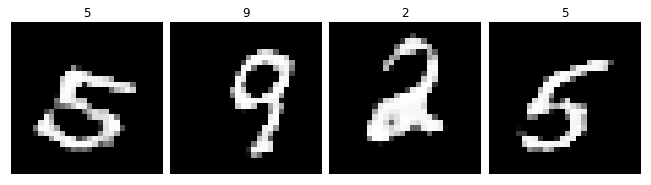

Iter: 8200; D loss: 0.0066; G_loss: -0.0008369


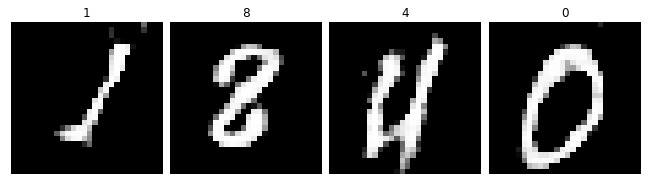

Iter: 8300; D loss: 0.00853; G_loss: -0.00652


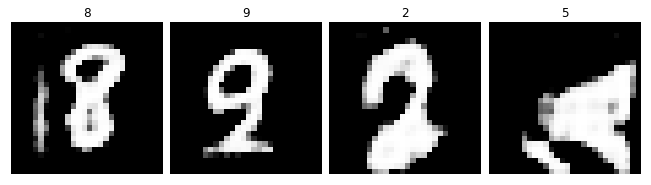

Iter: 8400; D loss: 0.01055; G_loss: -0.0008168


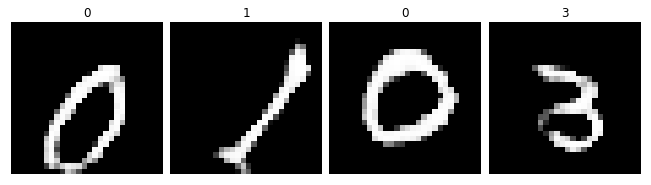

Iter: 8500; D loss: 0.007394; G_loss: -0.006797


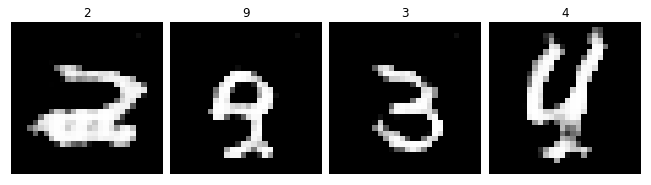

Iter: 8600; D loss: 0.0168; G_loss: -0.001458


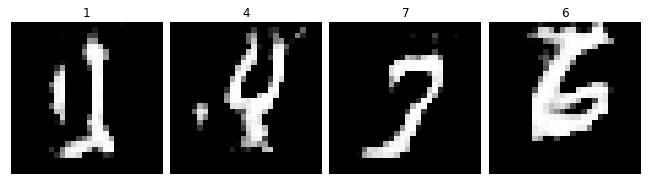

Iter: 8700; D loss: 0.01108; G_loss: -0.0146


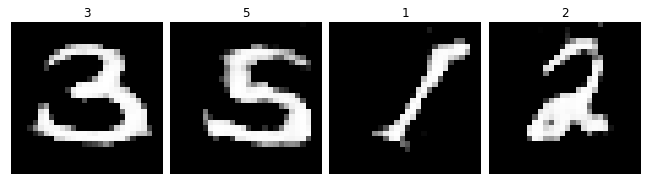

Iter: 8800; D loss: 0.01516; G_loss: -0.00114


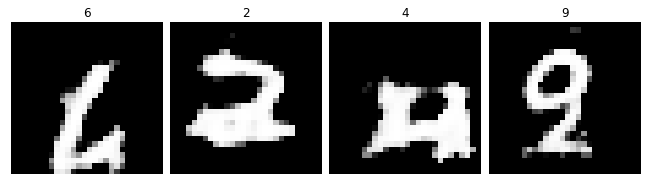

Iter: 8900; D loss: 0.01653; G_loss: -0.001155


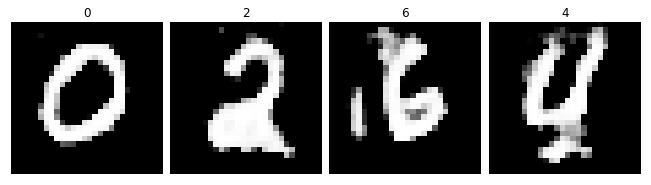

Iter: 9000; D loss: 0.009263; G_loss: -0.009604


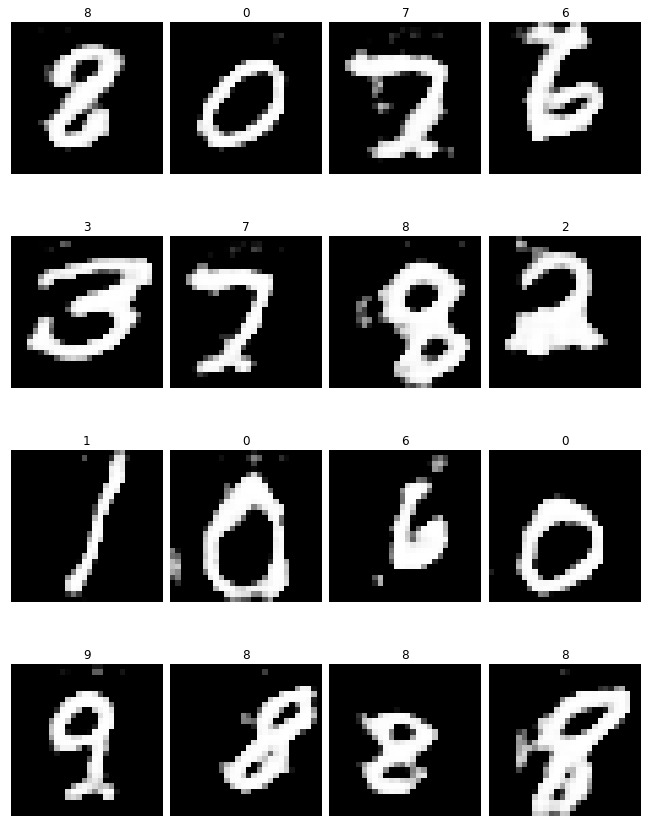

Iter: 9100; D loss: 0.01269; G_loss: -0.0009989


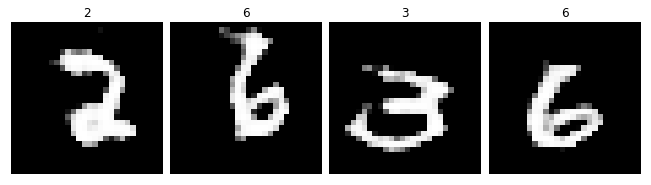

Iter: 9200; D loss: 0.007; G_loss: -0.00518


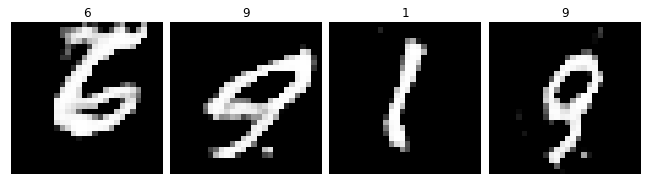

Iter: 9300; D loss: 0.01702; G_loss: -0.001255


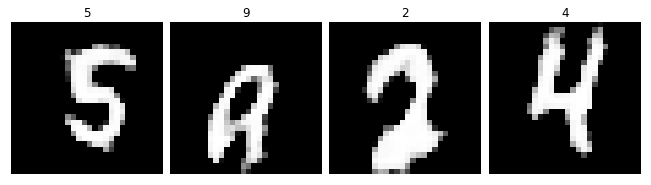

Iter: 9400; D loss: 0.01527; G_loss: -0.004593


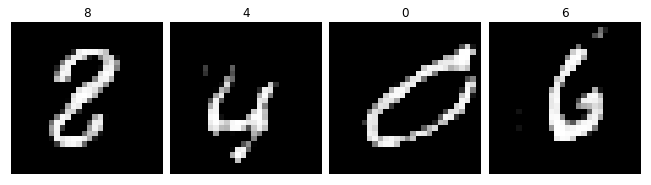

Iter: 9500; D loss: 0.01642; G_loss: -0.001419


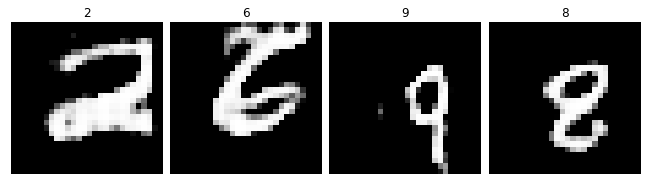

Iter: 9600; D loss: 0.00881; G_loss: -0.001184


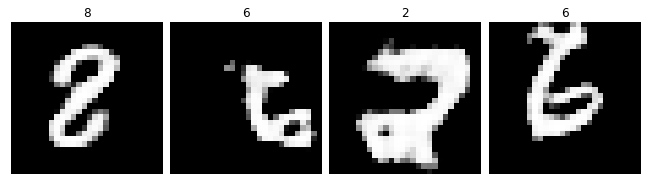

Iter: 9700; D loss: 0.01209; G_loss: -0.001085


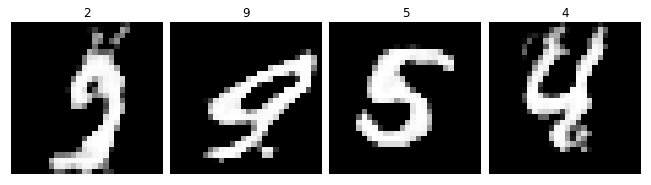

Iter: 9800; D loss: 0.01352; G_loss: -0.001285


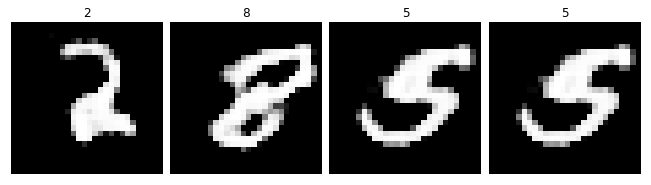

Iter: 9900; D loss: 0.009131; G_loss: -0.01112


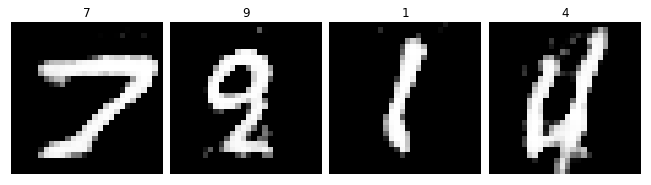

Iter: 10000; D loss: 0.01197; G_loss: -0.004927


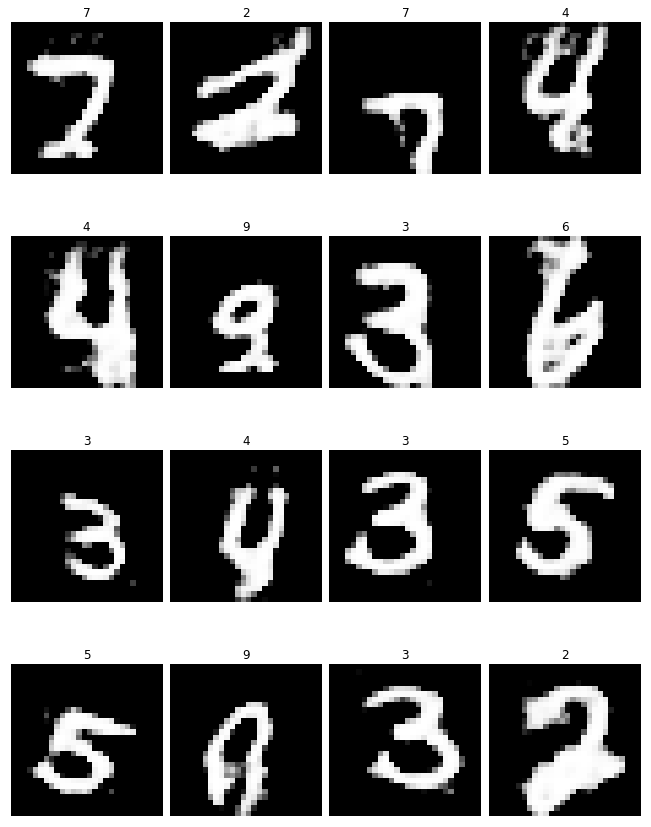

Iter: 10100; D loss: 0.01552; G_loss: -0.001786


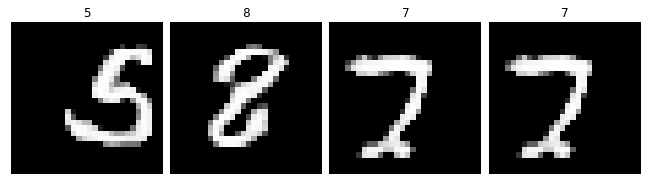

Iter: 10200; D loss: 0.01108; G_loss: -0.00105


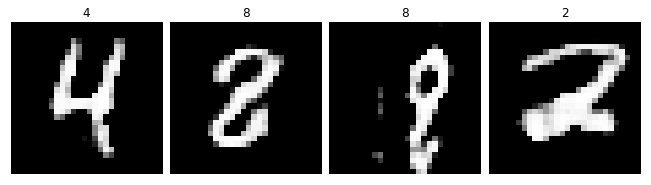

Iter: 10300; D loss: 0.01586; G_loss: -0.002161


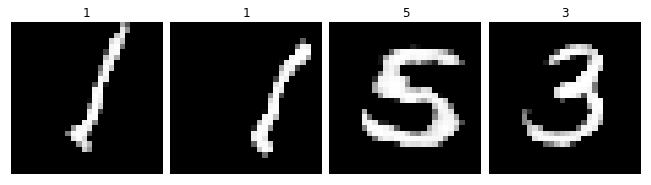

Iter: 10400; D loss: 0.01148; G_loss: -0.00103


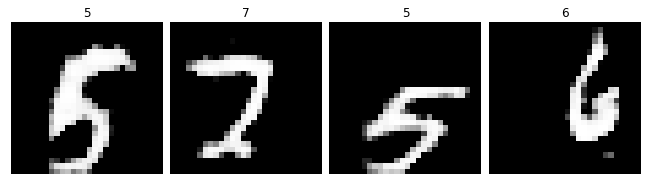

Iter: 10500; D loss: 0.01726; G_loss: -0.001033


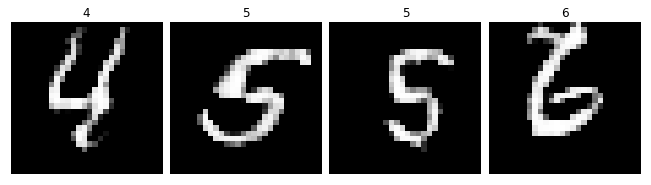

Iter: 10600; D loss: 0.01506; G_loss: -0.001296


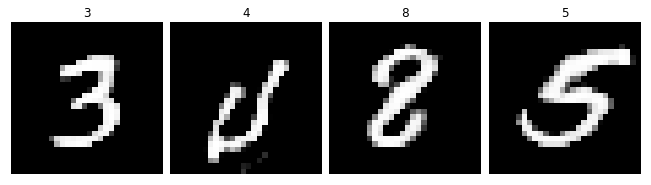

Iter: 10700; D loss: 0.01595; G_loss: -0.002403


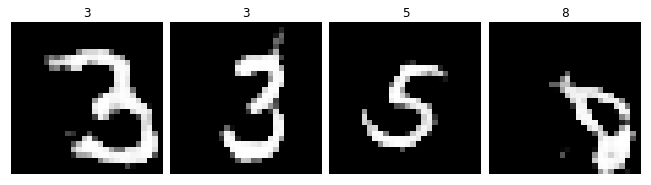

Iter: 10800; D loss: 0.01014; G_loss: -0.008122


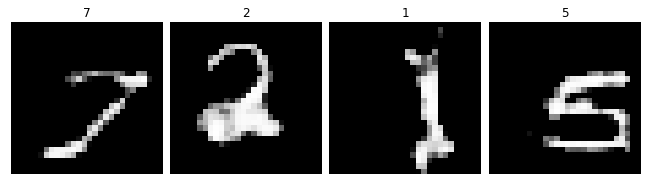

Iter: 10900; D loss: 0.01405; G_loss: -0.001039


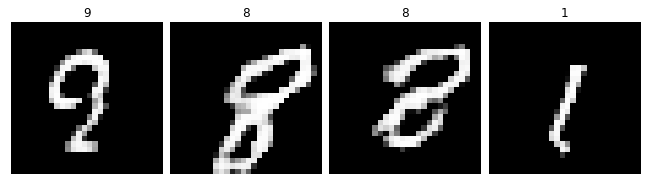

Iter: 11000; D loss: 0.004981; G_loss: -0.006771


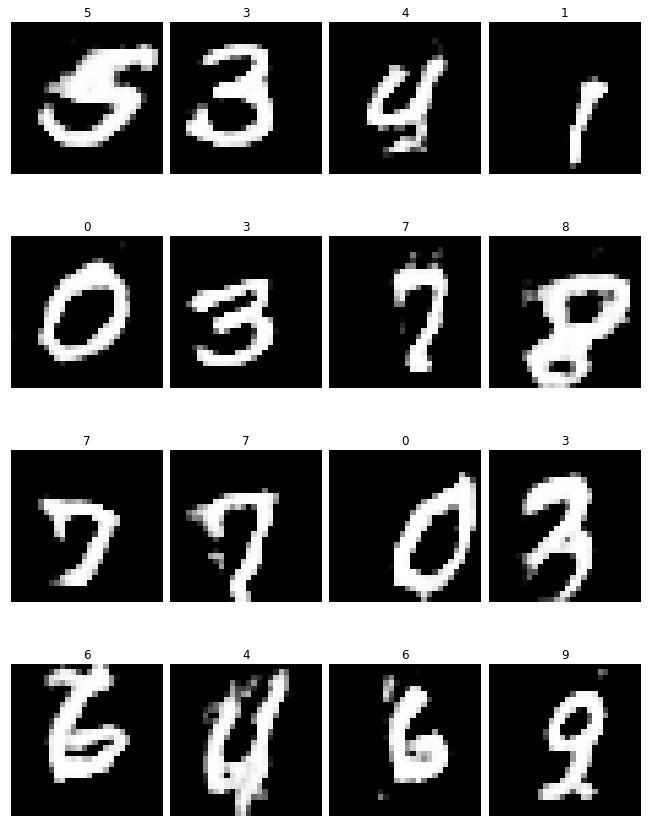

Iter: 11100; D loss: 0.01221; G_loss: -0.001279


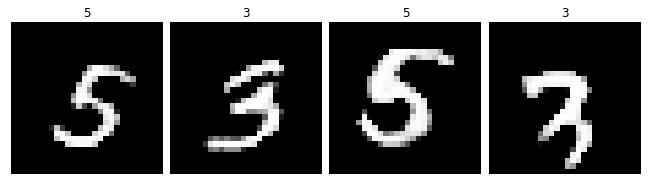

Iter: 11200; D loss: 0.01623; G_loss: -0.001092


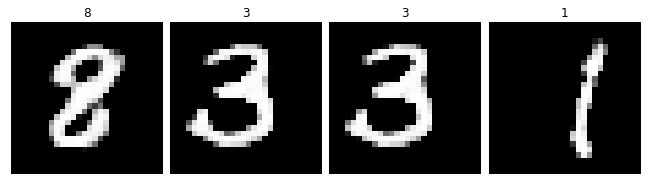

Iter: 11300; D loss: 0.01693; G_loss: -0.001319


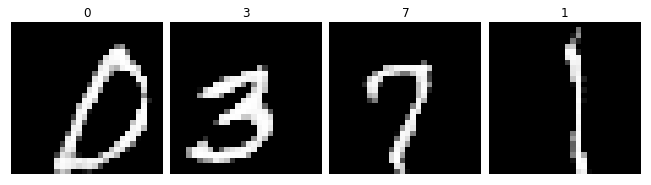

Iter: 11400; D loss: 0.01169; G_loss: -0.0132


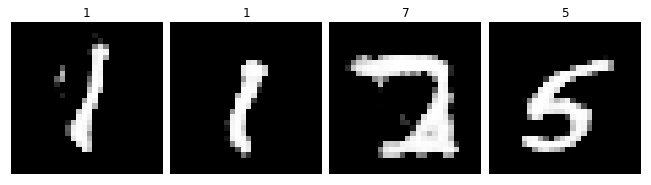

Iter: 11500; D loss: 0.01171; G_loss: -0.01311


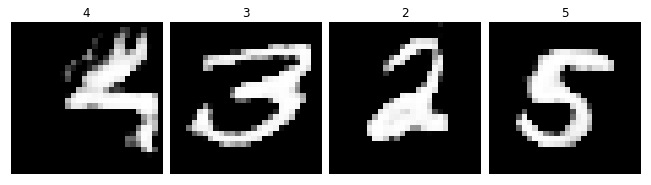

Iter: 11600; D loss: 0.01658; G_loss: -0.001483


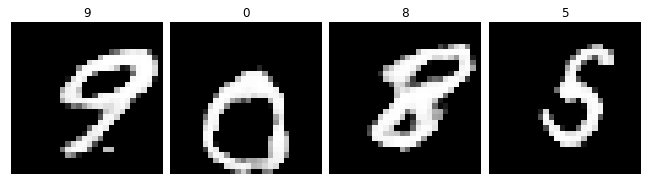

Iter: 11700; D loss: 0.01728; G_loss: -0.001327


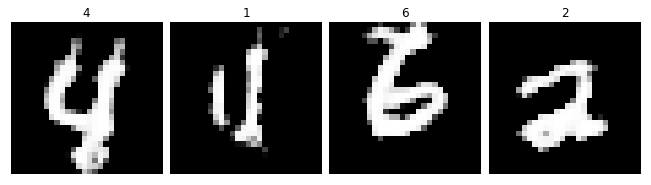

Iter: 11800; D loss: 0.007575; G_loss: -0.0009169


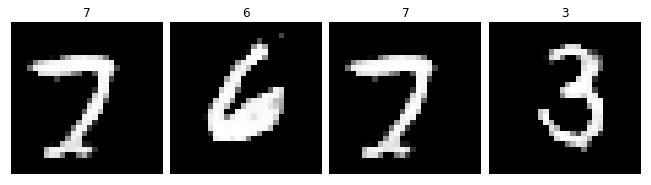

Iter: 11900; D loss: 0.009152; G_loss: -0.005966


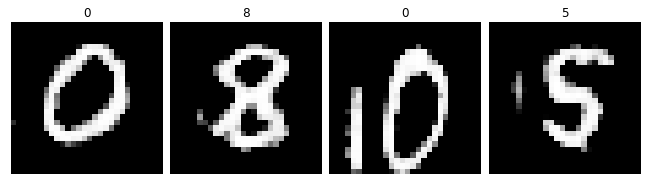

Iter: 12000; D loss: 0.01327; G_loss: -0.0009488


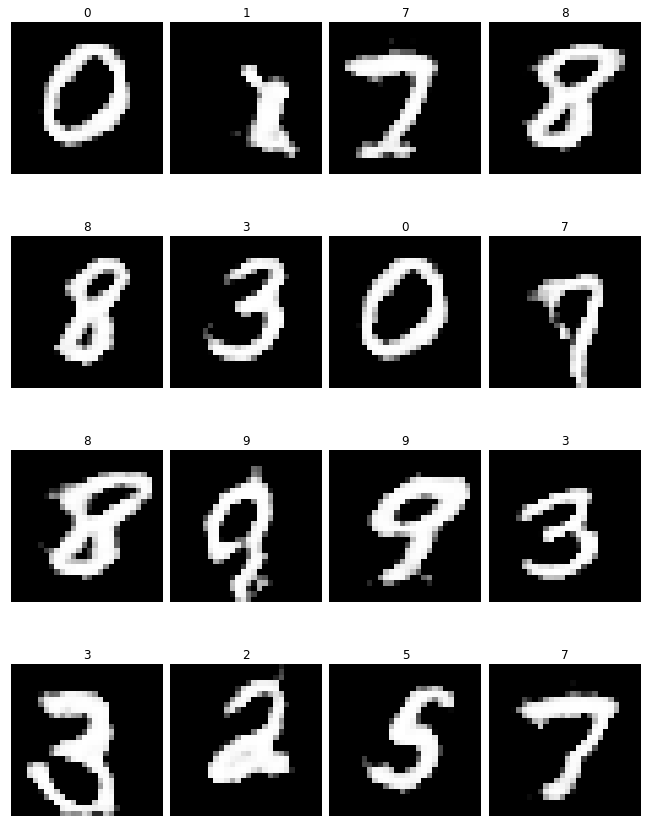

Iter: 12100; D loss: 0.01185; G_loss: -0.01146


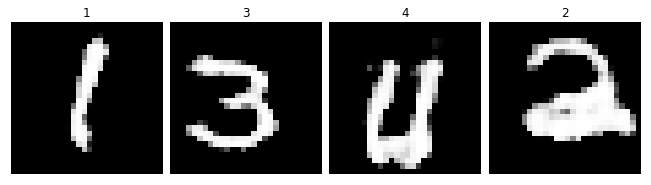

Iter: 12200; D loss: 0.01388; G_loss: -0.0008919


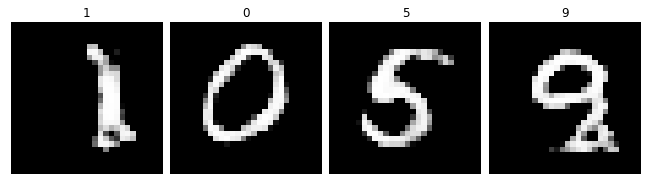

Iter: 12300; D loss: 0.01503; G_loss: -0.005085


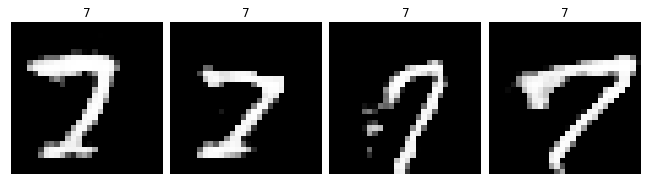

Iter: 12400; D loss: 0.01386; G_loss: -0.0009142


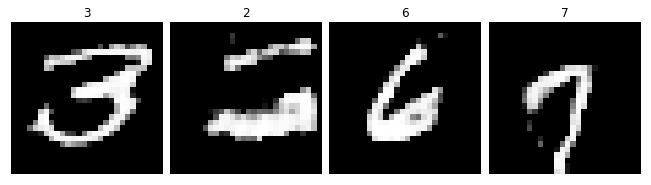

Iter: 12500; D loss: 0.01552; G_loss: -0.01179


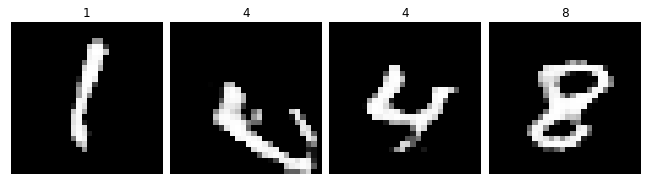

Iter: 12600; D loss: 0.01418; G_loss: -0.0009605


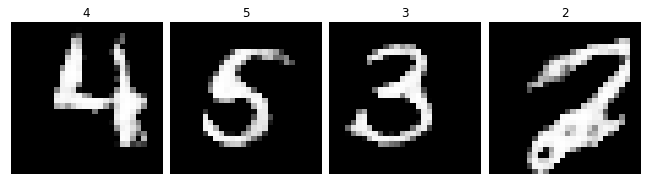

Iter: 12700; D loss: 0.01636; G_loss: -0.002459


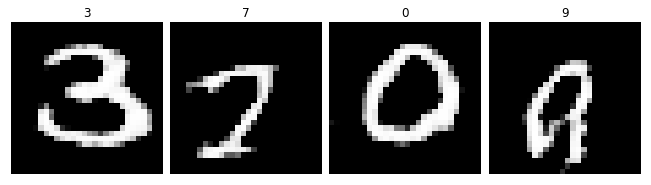

Iter: 12800; D loss: 0.01614; G_loss: -0.001333


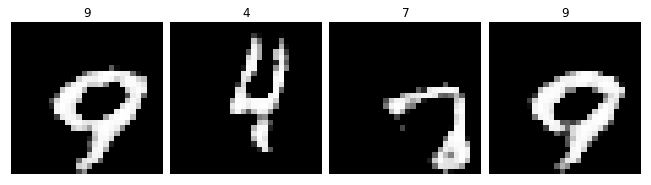

Iter: 12900; D loss: 0.01591; G_loss: -0.003195


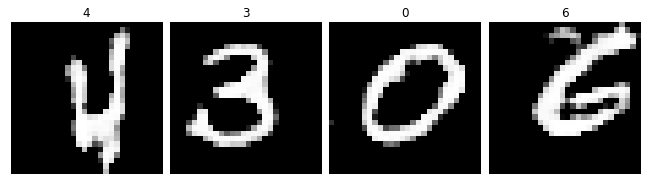

Iter: 13000; D loss: 0.01097; G_loss: -0.001025


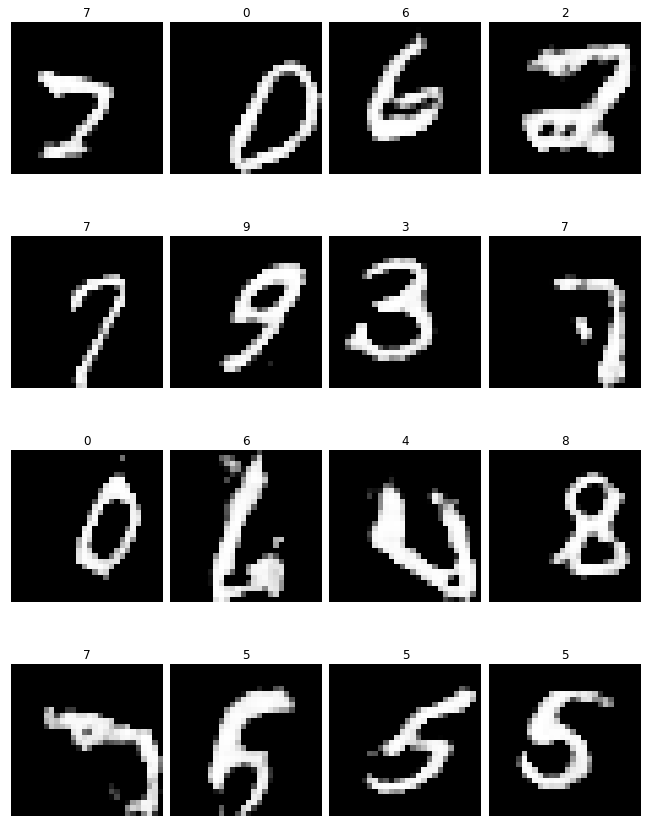

In [ ]:
#pretrain disc:
for t in tqdm(range(500)):
    #train discriminator
    Xdata, _ = mnist.train.next_batch(batch_size)
    (z, class_z) = sample_z(batch_size) #get Image Batch+Labels
    mean_image = getMeanImage(batch_size, class_z) #get mean_image
    #print("Pretrain Step ",t,"X ",Xdata.shape,"z ",z.shape,"z_class ",class_z.shape,"mean ",mean_image.shape)
    _, D_loss_curr, _ = sess.run(
        [D_solver, D_loss, clip_D],
        feed_dict={X: Xdata, Z:z, Class_z:class_z, Mean_image:mean_image}
    ) 
    
i = 0
for it in range(30000):
    for q in range(5): #train discriminator
        Xdata, _ = mnist.train.next_batch(batch_size)
        (z, class_z) = sample_z(batch_size) #get Image Batch+Labels
        _, D_loss_curr, _,summary = sess.run(
            [D_solver, D_loss, clip_D, merged_summary_op],
            feed_dict={X: Xdata, Z:z, Class_z:class_z, Mean_image:mean_image}
        )
        summary_writer.add_summary(summary, it+ q)
    (z, class_z) = sample_z(batch_size) #get Image Batch+Labels
    mean_image = getMeanImage(batch_size,class_z) #get mean_image
    _, G_loss_curr = sess.run(
        [G_solver, G_loss],
        feed_dict={Z:z, Class_z:class_z,Mean_image:mean_image}
    )

    if it % 100 == 0:
        print('Iter: {}; D loss: {:.4}; G_loss: {:.4}'
              .format(it, D_loss_curr, G_loss_curr))
        if it % 1000 == 0:
            (z, class_z) = sample_z(batch_size) #get Image Batch+Labels
            mean_image = getMeanImage(batch_size,class_z) #get mean_image
            samples = sess.run(detail_image, feed_dict={Z:z, Class_z:class_z,Mean_image:mean_image})         
            samples[0] = np.reshape(samples[0], (batch_size,28,28))
            fig = plot(samples[0][:16], np.argwhere(class_z!=0)[:,1],4,4)
            plt.savefig('out/{}.png'
                        .format(str(i).zfill(3)), bbox_inches='tight')
            plt.show()
            i += 1
        else:
            (z, class_z) = sample_z(batch_size) #get Image Batch+Labels
            mean_image = getMeanImage(batch_size,class_z) #get mean_image
            samples = sess.run(detail_image, feed_dict={Z:z, Class_z:class_z,Mean_image:mean_image})         
            samples[0] = np.reshape(samples[0], (batch_size,28,28))
            fig = plot(samples[0][:4], np.argwhere(class_z!=0)[:,1],1,4)
            plt.show()
            
plt.close(fig)